# Models: Collaborative Auto Encoder



[Variational AutoEncoders (VAE) with PyTorch](https://avandekleut.github.io/vae/)

[K-means, DBSCAN, GMM, Agglomerative clustering — Mastering the popular models in a segmentation problemK-means, DBSCAN, GMM, Agglomerative clustering — Mastering the popular models in a segmentation problem](https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29)


In [1]:
%load_ext autoreload
%autoreload 2
BASE_PATH='../..'

In [2]:
import sys
sys.path.append(f'{BASE_PATH}/lib')

In [3]:
import pytorch_common
pytorch_common.__version__

'0.0.23'

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from bunch import Bunch

import torch
from torch.utils.data import DataLoader
from torch.optim      import Adam

import pytorch_common.util as pu
from pytorch_common.callbacks.output import (
    Logger,
    MetricsPlotter
)
from pytorch_common.util import (
    set_device_name,
    get_device,
    LoggerBuilder
)

import model as ml

import data.dataset as ds
import data as dt

import logging
import random

import util as ut

## Setup

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available(), torch.__version__

(device(type='cuda', index=0), True, '1.11.0')

In [7]:
ut.set_seed(42)

Build dataset:

Clustering:

## Carga de dataset

In [8]:
dataset  = ds.MovieLensTMDBDatasetFactory.df_from_path(f'{BASE_PATH}/datasets')
train_ds = ds.CAEDataset(dataset)

In [9]:
movies_count = dataset.movie_seq.max() + 1
users_count  = dataset.user_seq.max() + 1

users_count, movies_count

(1885, 17611)

## Entrenamiento

In [10]:
params = Bunch({
    'lr'               : 0.0001,
    'epochs'           : 300,
    'latent_space_dim' : 100,
    'n_workers'        : 24,
    'batch_size'       : 64,
    'train'            : True
})

In [11]:
train_dl = DataLoader(
    train_ds, 
    batch_size  = params.batch_size,
    num_workers = params.n_workers,
    pin_memory  = True,
    shuffle     = True
)

In [12]:
model = ml.CollaborativeAutoEncoder(
    n_users            = users_count,
    n_item_ratings     = movies_count,
    latent_space_dim   = params.latent_space_dim
).to(pu.get_device())

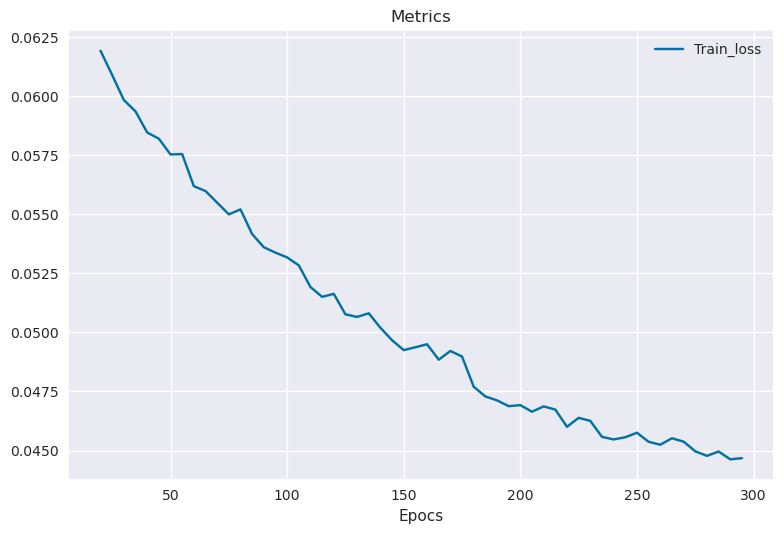

In [13]:
if params.train:
    result = model.fit(
        train_dl,
        epochs      = params.epochs,
        loss_fn     = ml.MSELossFn(),
        optimizer   = Adam(
            params = model.parameters(),
            lr     = params.lr
        ),
        callbacks   = [
            Logger(['time', 'epoch', 'train_loss']),
            MetricsPlotter(
                metrics            = ['train_loss'],
                warmup_count       = 3,
                plot_each_n_epochs = 5,
                reg_each_n_epochs  = 5
            ),
        ]
    )
    result.train_loss

In [ ]:
model.save('cae-checkpoint') if params.train else model.load('cae-checkpoint')

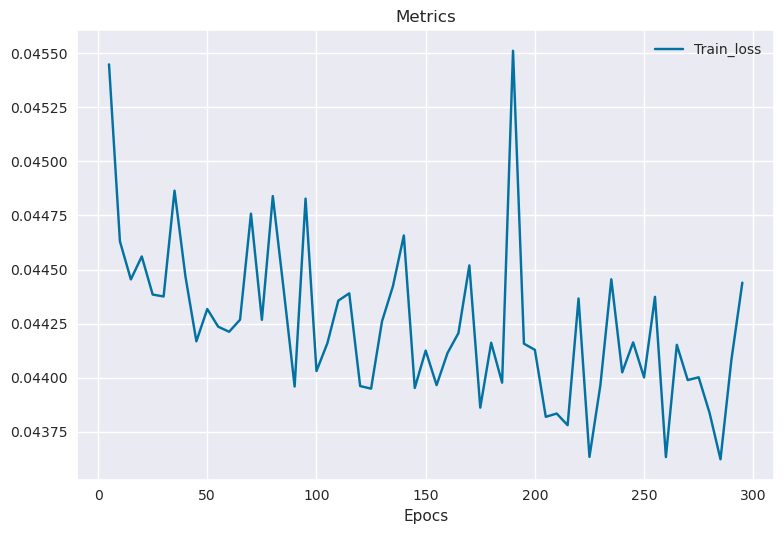

In [14]:
params = Bunch({
    'lr'               : 0.00001,
    'epochs'           : 300,
    'latent_space_dim' : 100,
    'n_workers'        : 24,
    'batch_size'       : 64,
    'train'            : True
})

if params.train:
    result = model.fit(
        train_dl,
        epochs      = params.epochs,
        loss_fn     = ml.MSELossFn(),
        optimizer   = Adam(
            params = model.parameters(),
            lr     = params.lr
        ),
        callbacks   = [
            Logger(['time', 'epoch', 'train_loss']),
            MetricsPlotter(
                metrics            = ['train_loss'],
                plot_each_n_epochs = 5,
                reg_each_n_epochs  = 5
            ),
        ]
    )
    result.train_loss

In [15]:
model.save('cae-checkpoint') if params.train else model.load('cae-checkpoint')

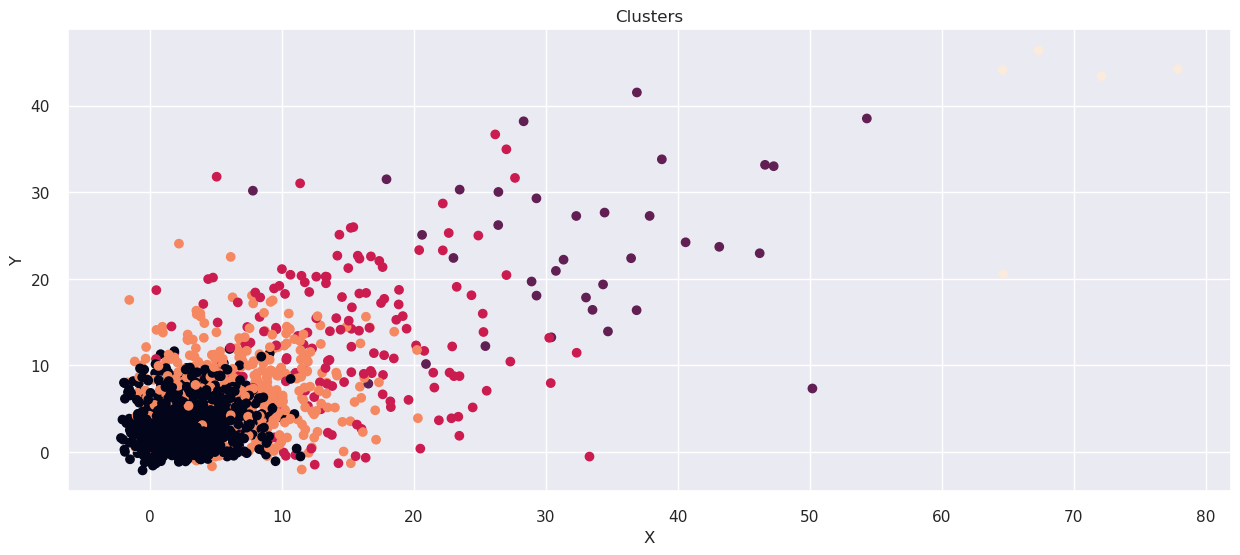

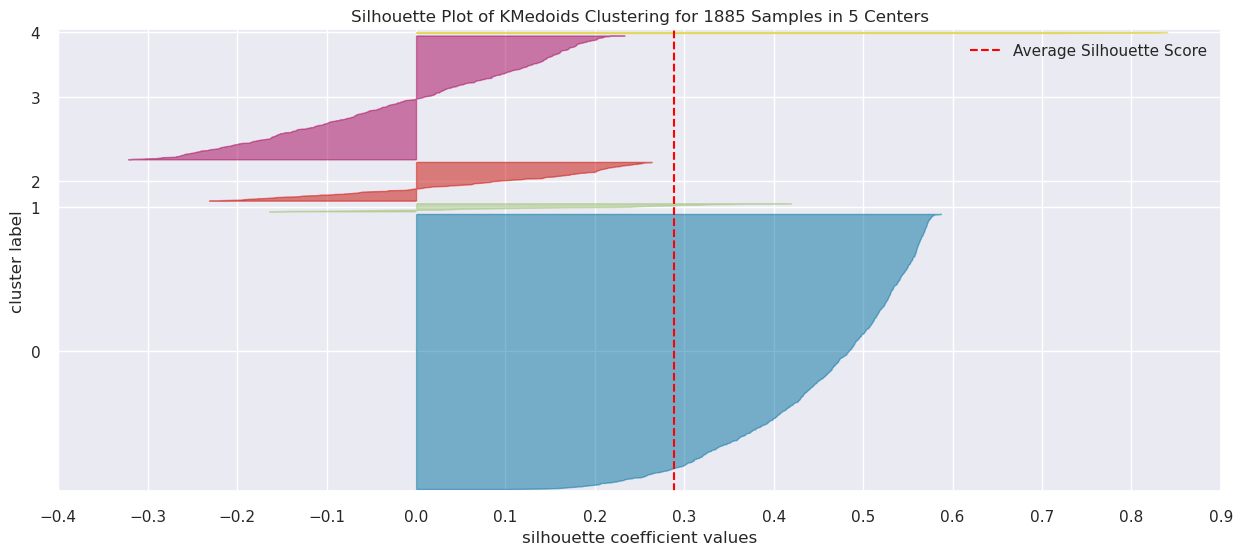

Silhouette: -0.29484352469444275


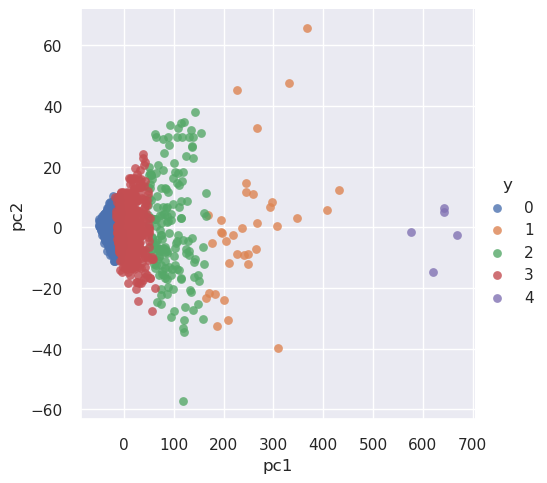

2023-03-25 11:26:48,985 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


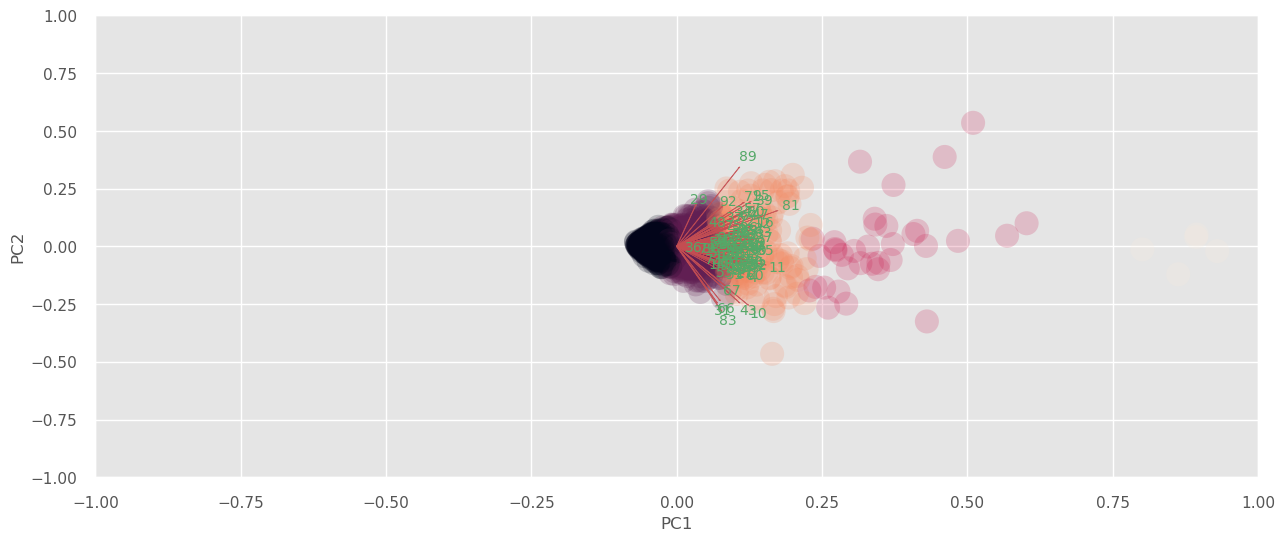

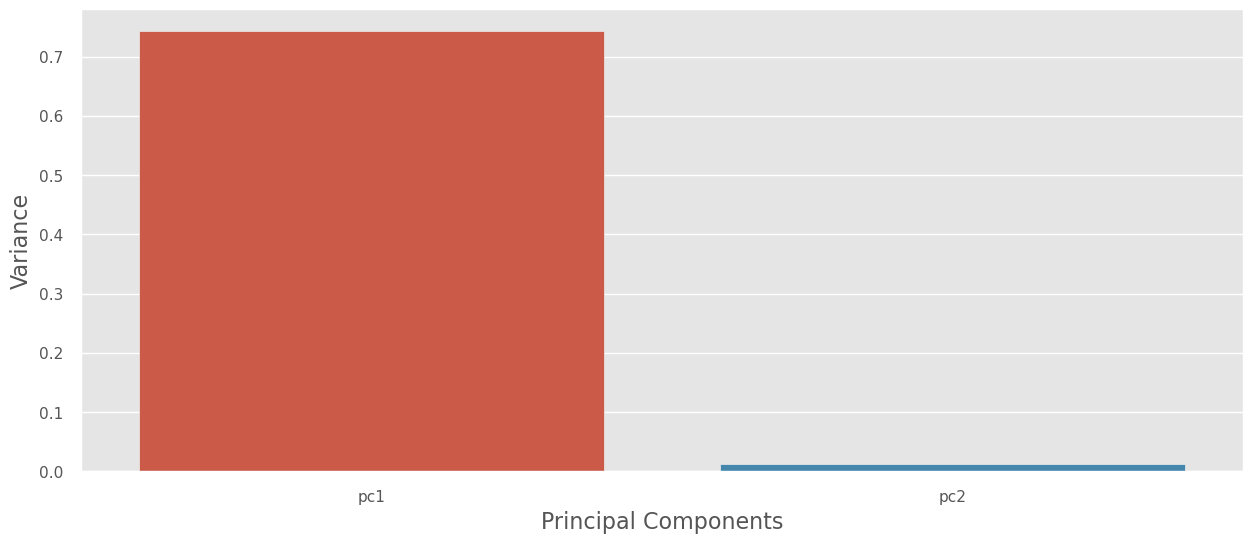

array([0.742388  , 0.01193673], dtype=float32)

In [20]:
latent_space = model.as_encoder()(train_ds)

medoids_result = ml.KMedoisClustering(n_clusters = 5) \
    .predict(latent_space) \
    .plot()

dt.PCAAnalisys \
    .make_on(
        X = pd.DataFrame(latent_space),
        y = medoids_result.labels,
        n_components = 2
    ) \
    .plot()